# Aihub 감성 대화 데이터에 대한 KoBERT 학습

## 1.Google Drive 연동
- 모델 파일과 학습 데이터가 저장 되어있는 구글 드라이브의 디렉토리와 Colab을 연동.  
- 좌측상단 메뉴에서 런타임-> 런타임 유형 변경 -> 하드웨어 가속기 -> GPU 선택 후 저장

### GPU 사양 확인

In [ ]:
!nvidia-smi

Sat Aug 28 13:17:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Google Drive 연동
아래 코드를 실행후 나오는 URL을 클릭하여 나오는 인증 코드 입력

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**필요 패키지 설치**

In [ ]:
!pip install -r drive/'My Drive'/ML/KDT/Final/conversationModel/requirements.txt

## KoBERT Classification Training

### 환경 세팅

**Path 추가**

In [ ]:
root_path = "drive/My Drive/ML/KDT/Final"
code_path = f"{root_path}/conversationModel"
data_path = f"{root_path}/dataset/corpus_labeled.xlsx"
checkpoint_path = f"{code_path}/checkpoint"
save_ckpt_path = f"{checkpoint_path}/kobert-emotion-text-classification.pth"

import sys
sys.path.append(f'{root_path}/')
sys.path.append(f'{code_path}/')

**import package**

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from tqdm import tqdm

import torch
from transformers import AdamW
from torch.utils.data import dataloader
from conversationModel.dataloader.emotion import EmotionTextClassificationDataset
from conversationModel.model.kobert import KoBERTforSequenceClassification

from sklearn.preprocessing import LabelEncoder
from sklearn.externals import joblib

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
torch.cuda.is_available()

True

### Data Labeling

**Label Encoder**

In [ ]:
corpus = pd.read_excel(root_path + '/dataset/corpus.xlsx')

labelencoder = LabelEncoder()
labelencoder.fit(corpus['감정_소분류'])
corpus['감정_레이블'] = labelencoder.transform(corpus['감정_소분류'])

labelencoder.classes_

array(['가난한, 불우한', '감사하는', '걱정스러운', '고립된', '괴로워하는', '구역질 나는', '기쁨', '낙담한',
       '남의 시선을 의식하는', '노여워하는', '눈물이 나는', '느긋', '당혹스러운', '당황', '두려운',
       '마비된', '만족스러운', '방어적인', '배신당한', '버려진', '부끄러운', '분노', '불안', '비통한',
       '상처', '성가신', '스트레스 받는', '슬픔', '신뢰하는', '신이 난', '실망한', '악의적인',
       '안달하는', '안도', '억울한', '열등감', '염세적인', '외로운', '우울한', '자신하는', '조심스러운',
       '좌절한', '죄책감의', '질투하는', '짜증내는', '초조한', '충격 받은', '취약한', '툴툴대는',
       '편안한', '한심한', '혐오스러운', '혼란스러운', '환멸을 느끼는', '회의적인', '후회되는', '흥분',
       '희생된'], dtype=object)

**Labeling 결과 및 Encoder 저장**

In [ ]:
corpus.to_excel(data_path, engine='xlsxwriter')  # 인코딩된 데이터 저장

joblib.dump(labelencoder, checkpoint_path + '/labelencoder.pkl') # 인코더 저장

['drive/My Drive/ML/KDT/Final/conversationModel/checkpoint/labelencoder.pkl']

### KoBERT Classification Training for Emotion dataset

**Train 함수**

In [ ]:
def train(device, epoch, model, optimizer, train_loader, save_step, save_ckpt_path, train_step = 0):
    losses = []
    train_start_index = train_step + 1 if train_step != 0 else 0
    total_train_step = len(train_loader)
    model.train()

    with tqdm(total= total_train_step, desc=f"Train({epoch})") as pbar:
        pbar.update(train_step)
        for i, data in enumerate(train_loader):
            if i < train_start_index: continue

            optimizer.zero_grad()
            outputs = model(**data)

            loss = outputs[0]

            losses.append(loss.item())

            loss.backward()
            optimizer.step()

            pbar.update(1)
            pbar.set_postfix_str(f"Loss: {loss.item():.3f} ({np.mean(losses):.3f})")

            # 학습 진행상황 저장
            if i >= total_train_step or i % save_step == 0:
                torch.save({
                    'epoch': epoch,  # 현재 학습 epoch
                    'model_state_dict': model.state_dict(),  # 모델 저장
                    'optimizer_state_dict': optimizer.state_dict(),  # 옵티마이저 저장
                    'train_step': i,  # 현재 진행한 학습
                }, save_ckpt_path)

    return np.mean(losses)

**Training 진행**

load pretrain from: drive/My Drive/ML/KDT/Final/conversationModel/checkpoint/kobert-emotion-text-classification.pth, epoch=34


Train(49): 100%|██████████| 5759/5759 [41:41<00:00,  2.30it/s, Loss: 0.077 (0.087)]


,loss
0,0.145530
1,0.173442
2,0.154108
3,0.146757
4,0.141249
5,0.128890
6,0.123618
7,0.119644
8,0.113378
9,0.108592


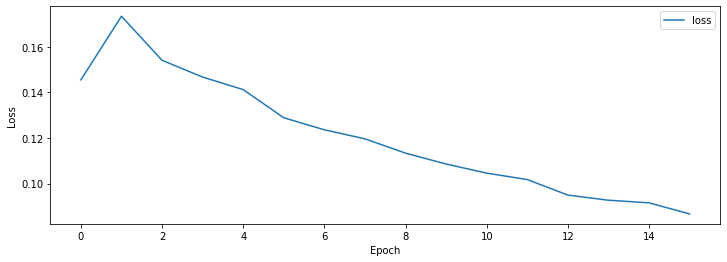

In [ ]:
n_epoch = 50          # Num of Epoch
batch_size = 13      # 배치 사이즈
ctx = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(ctx)
save_step = 100 # 학습 저장 주기
learning_rate = 5e-6  # Learning Rate
num_labels = len(labelencoder.classes_) # label

# EmotionTextClassificationDataset 데이터 로더
dataset = EmotionTextClassificationDataset(file_path=data_path, device=device)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model = KoBERTforSequenceClassification(num_labels=num_labels)
model.to(device)

# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
      'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

pre_epoch, pre_loss, train_step = 0, 0, 0
if os.path.isfile(save_ckpt_path):b
    checkpoint = torch.load(save_ckpt_path, map_location=device)
    pre_epoch = checkpoint['epoch']
    train_step =  checkpoint['train_step']

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print(f"load pretrain from: {save_ckpt_path}, epoch={pre_epoch}")

losses = []
offset = pre_epoch


for step in range(n_epoch - offset):
    epoch = step + offset
    loss = train(device, epoch, model, optimizer, train_loader, save_step, save_ckpt_path, train_step)
    losses.append(loss)
    train_step = 0

# data
data = {
    "loss": losses
}
df = pd.DataFrame(data)
display(df)

# graph
plt.figure(figsize=[12, 4])
plt.plot(losses, label="loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()